# Import libraries

In [16]:
from functions.vectorization import *
from functions.labelization import *
from functions.vocabulary import *
from functions.model import *
from functions.predict import *
from functions.tools import *
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# Import data

In [17]:
path_test = '../../data/test/estudio_fp_informatica.json'
df_test = pd.read_json(path_test, orient='records')
# Set to upper the column names
df_test.columns = [x.upper() for x in df_test.columns]
# df_test['ID_PUESTO_ESCO_ULL'] = df_test['ID_PUESTO_ESCO_ULL'].apply(lambda x: str(int(x)))
df_test['NUM_WORDS'] = count_words(df_test)
df_test.head()

,ID_OFERTA,CATEGORIA,SUBCATEGORIA,PALABRAS_EMPLEO_TEXTO,ID_PUESTO_ESCO,NUM_WORDS
0,3a082f4f434fad8f4984cd46e3f3b6,Informática y telecomunicaciones,Telecomunicaciones,TECNICO REPARACIONES EQUIPOS ELECTRONICA COMUN...,NaN,21
1,ff4c8610f84d9d8e34db65fae10012,Informática y telecomunicaciones,Calidad,CONSULTOR ESPECIALISTA SEO CLIENTES EQUIPOS EX...,937.0,57
2,dee03c68724887a5132271d3f23091,Informática y telecomunicaciones,Programación,EXPERIENCIA REDACCION WEB WORDPRESS PRESTASHOP...,NaN,14
3,d205ab34f74b9cbae77b43f5f1968b,Informática y telecomunicaciones,Sistemas,ADMINISTRACION SISTEMA MONITORIZACION MARCAS T...,966.0,45
4,61518c0bc649cc9494628764f36472,Informática y telecomunicaciones,Sistemas,COORDINADOR SERVICIOS SOPORTES APLICACIONES GE...,NaN,25


# Vectorize test offers and id to label

In [18]:
path_vocabulary = '../../data/training_clasifier_infojobs_21_23/vocabulary.json'
vocabulary = load_vocabulary(path_vocabulary)
test_vectors = np.vstack(create_vectorize_dataframe(df_test, vocabulary))
path_ids_labels = '../../data/training_clasifier_infojobs_21_23/ids_labels.json'
dict_label_ids = load_dict_label_ids(path_ids_labels)

# Load model

In [19]:
path_model= '../../data/training_clasifier_infojobs_21_23/my_model_V20.h5'
model = load_model(path_model)

# Get accuracy and predictions

In [20]:
# Get the accuracy for this TEST
# accuracy = get_accuracy(model, test_vectors, dict_label_ids, real_ids)
# Print the value of accuracy in percentage with 2 decimals
# print('Accuracy: {:.2%}'.format(accuracy))
# Get predictions for this TEST
predictions_id, probability = get_predictions(model, test_vectors, dict_label_ids)

350/350 [==============================] - 1s 2ms/step


# Create report

In [21]:
df_report = pd.DataFrame({'ID_OFERTA': df_test['ID_OFERTA'],
                            'PREDICTED_ID': predictions_id,
                            'PROBABILITY': probability,
                            'NUM_OF_WORDS': df_test['NUM_WORDS']})
df_report.head()
df_report.to_csv('../../data/training_clasifier_infojobs_21_23/results.csv', index=False)

# Count etiquated offers

In [22]:
# Calculate the number of offers with ID_PUESTO_ESCO in df_test
count = df_test.shape[0]
print('Number of offers: {}'.format(count))
# Delete all NaN values in the column ID_PUESTO_ESCO of the dataframe df_test
df_test = df_test.dropna(subset=['ID_PUESTO_ESCO'])
final_count = df_test.shape[0]
# Calculate the number of offers with ID_PUESTO_ESCO in df_test
print('Number of offers with ID_PUESTO_ESCO: {}'.format(final_count))

Number of offers: 11184
Number of offers with ID_PUESTO_ESCO: 7450


# Show accuracy

In [23]:
# Convert the column ID_PUESTO_ESCO to integer
df_test['ID_PUESTO_ESCO'] = df_test['ID_PUESTO_ESCO'].apply(lambda x: int(x))
# Create a new column with the predicted label for the corresponding ID_OFERTA on the dataframe df_test from the dataframe df_report
df_test['PREDICTED_ID'] = df_test['ID_OFERTA'].apply(lambda x: df_report[df_report['ID_OFERTA'] == x]['PREDICTED_ID'].values[0])
# Add the column PROBABILITY for the corresponding ID_OFERTA on the dataframe df_test from the dataframe df_report
df_test['PROBABILITY'] = df_test['ID_OFERTA'].apply(lambda x: df_report[df_report['ID_OFERTA'] == x]['PROBABILITY'].values[0])
# Calculate the accuracy
accuracy = accuracy_score(df_test['ID_PUESTO_ESCO'], df_test['PREDICTED_ID'])
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 32.64%


# Get test stadistics

In [24]:
# Create a new column with the matching between the predicted label and the real label
df_test['MATCH'] = df_test.apply(lambda x: 1 if x['ID_PUESTO_ESCO'] == x['PREDICTED_ID'] else 0, axis=1)
# Calculate the mean and std of the PROBABILITY column for the matching offers
mean_match = df_test[df_test['MATCH'] == 1]['PROBABILITY'].mean()
std_match = df_test[df_test['MATCH'] == 1]['PROBABILITY'].std()
# Calculate the mean and std of the PROBABILITY column for the non-matching offers
mean_no_match = df_test[df_test['MATCH'] == 0]['PROBABILITY'].mean()
std_no_match = df_test[df_test['MATCH'] == 0]['PROBABILITY'].std()
# Print the results
print('Mean of the probability for the matching offers: {:.2}'.format(mean_match))
print('Std of the probability for the matching offers: {:.2}'.format(std_match))
print('Mean of the probability for the non-matching offers: {:.2}'.format(mean_no_match))
print('Std of the probability for the non-matching offers: {:.2}'.format(std_no_match))

Mean of the probability for the matching offers: 0.61
Std of the probability for the matching offers: 0.28
Mean of the probability for the non-matching offers: 0.45
Std of the probability for the non-matching offers: 0.28


# Show graph with the probability distribution and matchings

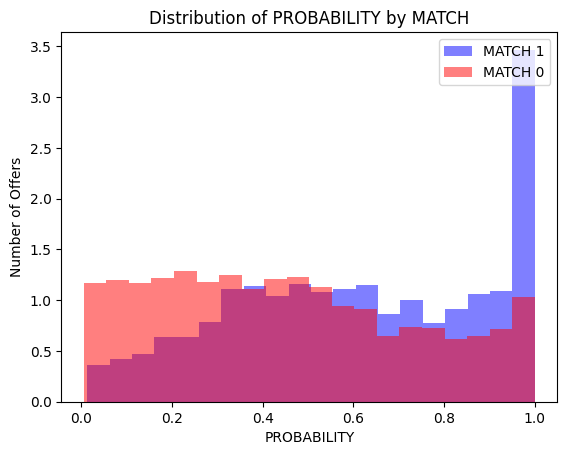

In [30]:
import matplotlib.pyplot as plt

# Create a histogram for MATCH == 1 (right side) with blue color
plt.hist(df_test[df_test['MATCH'] == 1]['PROBABILITY'], bins=20, alpha=0.5, color='blue', label='MATCH 1', density=True)

# Create a histogram for MATCH == 0 (left side) with red color
plt.hist(df_test[df_test['MATCH'] == 0]['PROBABILITY'], bins=20, alpha=0.5, color='red', label='MATCH 0', density=True)

# Set labels and title
plt.xlabel('PROBABILITY')
plt.ylabel('Number of Offers')
plt.title('Distribution of PROBABILITY by MATCH')

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.show()
